# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('setpoints', 'TA01_GT10X_GM10X_default')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID               
flow          TA01_GP101_default          0
temperatures  DC_GT401_GM401              0
              TA01_GT10X_GM10X            0
              DC_GT301_damped             0
              DC_GT301_outdoor            0
setpoints     TA01_GT10X_GM10X_default    0
dtype: int64





In [6]:
# describe cols
data.describe().transpose()

count         mean         std  \
category     sensor_ID                                                     
flow         TA01_GP101_default        166921.0  2354.738858  631.850358   
temperatures DC_GT401_GM401            166921.0    49.677559    3.609970   
             TA01_GT10X_GM10X          166921.0    20.287643    1.043412   
             DC_GT301_damped           166921.0    -5.166278    6.829758   
             DC_GT301_outdoor          166921.0    -5.192088    6.828700   
setpoints    TA01_GT10X_GM10X_default  166921.0    20.330416    0.712380   

                                        min     25%     50%     75%     max  
category     sensor_ID                                                       
flow         TA01_GP101_default         0.0  1864.0  2114.8  2718.4  4206.6  
temperatures DC_GT401_GM401             0.0    49.0    50.4    51.6    55.9  
             TA01_GT10X_GM10X           0.0    19.9    20.1    20.5    29.2  
             DC_GT301_damped          -21.6   -10.8    -3.8     0.5     8.4  
             DC_GT301_outdoor         -20.5   -10.8    -3.8     0.5     7.9  
setpoints    TA01_GT10X_GM10X_default   0.0    20.0    20.0    20.0    22.0

## Process / transform variables 

In [7]:
# remove erroneous setpoints data
#data[data.setpoints.TA01_GT10X_GM10X_default == 0.0].TA01_GT10X_GM10X_default = 20.0
data = data[data.setpoints.TA01_GT10X_GM10X_default != 0.0]

## Use temperature Diff. w.r.t. setpoint
#data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
#    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# Transform setpoints variable to instead account for difference w.r.t 20 deg C
data[('temperatures', 'setpoint_diff')] = data.setpoints.TA01_GT10X_GM10X_default - 20.0

In [8]:
# create variable f. time to account for time-specific effects (e.g. transpiration)

data[('time', 'minutes')] = data.index.get_level_values(3)
data[('time', 'min_sin')] = data.time.minutes.apply(
    lambda d: abs(np.sin((d.hour * 60 + d.minute) * (2 * np.pi / (24 * 60 * 60))))
)
data[('time', 'min_cos')] = data.time.minutes.apply(
    lambda d: abs(np.cos((d.hour * 60 + d.minute) * (2 * np.pi / (24 * 60 * 60))))
)

### Plot pairwise correlation matrix

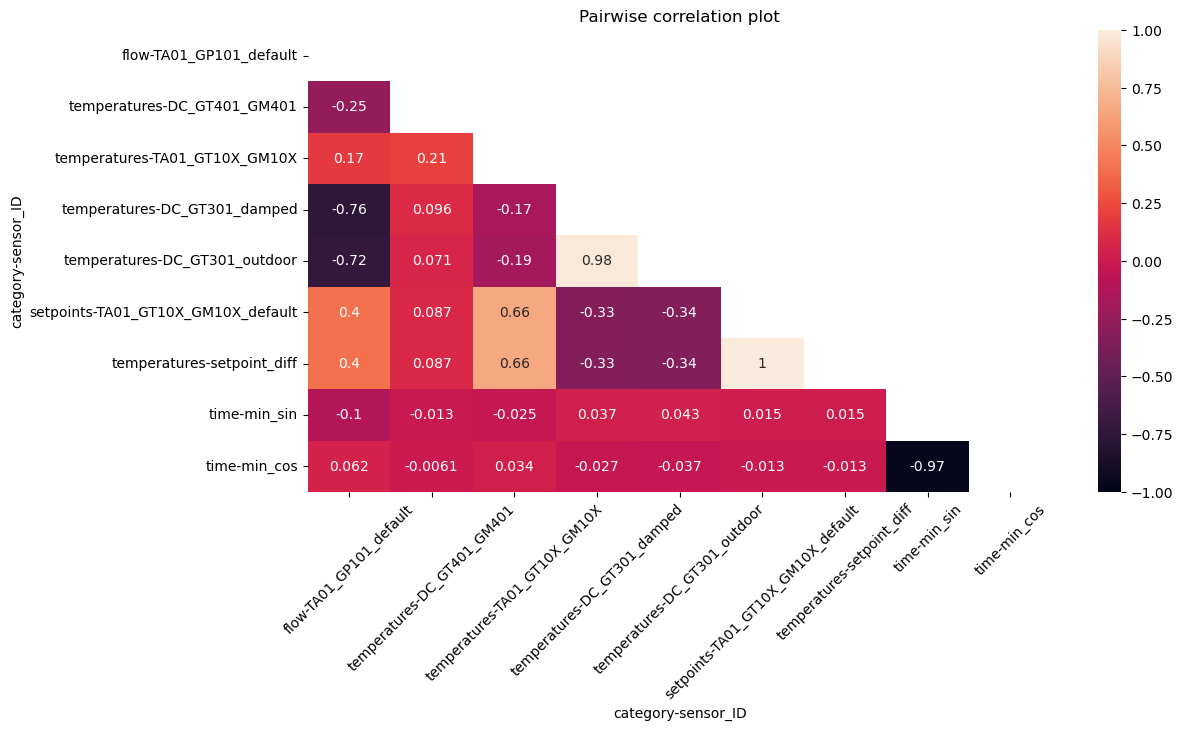

In [9]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

plt.xticks(rotation=45)
plt.title('Pairwise correlation plot')
plt.show()

# delete correlation data
del corr

## Preparing data

In [10]:
t_steps = 20  # 10 minute predictions
n_steps = 60  # 30 minute backwards look

train_frac = 0.8

### Data selection and whitening

In [11]:
# save temp mean & std

temp_mean = data.temperatures.TA01_GT10X_GM10X.mean()
temp_std = data.temperatures.TA01_GT10X_GM10X.std()

In [12]:
# normalize all columns
for col in data.columns:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

In [13]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101_default'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('temperatures', 'setpoint_diff')
]

# filter data
data = data[model_vars]

In [14]:
# define target
targets = data.pop(('temperatures', 'TA01_GT10X_GM10X')).shift(periods=-t_steps)  # 5-minute forward

# remove NaNs
targets = targets.iloc[:-t_steps]
data = data.iloc[:-t_steps]

### Create sequences

In [15]:
def date_flagger(data, n_steps):
    # get flagged dates
    data['day'] = data.index.get_level_values(1).values
    data['date_flag'] = data.day - data.day.shift(periods=n_steps) > 1

    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['day'], data['date_flag']
    
    return flagged_idx

In [16]:
# get all n_step-sequences from data series
sequences = np.stack([
    data.values[i:i+n_steps, :] for i in range(len(data) - n_steps)
]) 

# get flagged sequences
flags = date_flagger(data, n_steps)

# get mask f. flags
mask = [idx not in flags for idx in range(len(sequences))]
sequences = sequences[mask]

# get targets, delete mask
targets = targets.values[n_steps:][mask]

In [17]:
# delete data 
del data

# save sequential seqs, targets for testing
sequences, test_seqs  = sequences[:-8640], sequences[-8640:]
targets, test_targets = targets[:-8640], targets[-8640:]

### Shuffle and split dataset

In [18]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
sequences = np.squeeze(sequences[idxs])
targets = np.squeeze(targets[idxs])


In [19]:
# split data
train_n = int(len(targets) * train_frac)
#test_n = len(targets) - train_n

X_train, X_test = sequences[:train_n], sequences[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [20]:
# delete vars
del sequences, targets

## Define model

In [21]:
# layerList = [
#     layers.Input(shape=(
#         X_train.shape[1],
#         X_train.shape[2]
#     )),
#     layers.Conv1D(
#         filters=64,
#         kernel_size=7, 
#         padding="same", 
#         strides=2, 
#         activation="relu"
#     ),
#     layers.SpatialDropout1D(rate=0.2),
#     layers.Conv1D(
#         filters=32,
#         kernel_size=7, 
#         padding="same", 
#         strides=2, 
#         activation="relu"
#     ),
#     layers.SpatialDropout1D(rate=0.2),
#     layers.Flatten(),
#     layers.Dense(
#         units=128, 
#         activation='relu',
#         kernel_regularizer='l2',
#         activity_regularizer='l2'
#     ),
#     layers.Dropout(rate=0.2),
#     layers.Dense(
#         units=128, 
#         activation='relu',
#         kernel_regularizer='l2',
#         activity_regularizer='l2'
#     ),
#     layers.Dense(1, activation=None)
# ]

In [22]:
# layerList = [
#     layers.Input(shape=(
#         X_train.shape[1],
#         X_train.shape[2]
#     )),
#     layers.Conv1D(
# #         filters=64,
#         filters=128,
#         kernel_size=7, 
#         padding="same", 
#         strides=2, 
#         activation="relu"
#     ),
#     layers.SpatialDropout1D(rate=0.2),
#     layers.Conv1D(
# #         filters=32,
#         filters=64,
#         kernel_size=7, 
#         padding="same", 
#         strides=2, 
#         activation="relu"
#     ),
#     layers.SpatialDropout1D(rate=0.2),
#     layers.LSTM(
#         units=32,
#         activation='tanh',
#         return_sequences=True,
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.2
#     ),
#     layers.LSTM(
#         units=16,
#         activation='tanh',
#         recurrent_activation='sigmoid',
#         activity_regularizer='l2',
#         recurrent_dropout=0.2
#     ),
#     layers.Dense(
#         units=1,
#         activation=None,
#         activity_regularizer='l2'
#     )
# ]

In [23]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        X_train.shape[2]
    )),
    layers.LSTM(
        units=32,
        activation='tanh',
        return_sequences=True,
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.SpatialDropout1D(rate=0.2),
    layers.LSTM(
        units=32,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.Dropout(rate=0.2),
    layers.Dense(
        units=64,
        activation='sigmoid',
        activity_regularizer='l2'
    ),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [24]:
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 32)            4864      
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 32)           0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

In [25]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=40,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/40
790/790 [==============================] - 83s 99ms/step - loss: 0.6426 - val_loss: 0.4494
Epoch 2/40
790/790 [==============================] - 86s 110ms/step - loss: 0.4611 - val_loss: 0.3925
Epoch 3/40
790/790 [==============================] - 105s 133ms/step - loss: 0.4246 - val_loss: 0.3942
Epoch 4/40
790/790 [==============================] - 108s 137ms/step - loss: 0.4048 - val_loss: 0.3763
Epoch 5/40
790/790 [==============================] - 481s 609ms/step - loss: 0.3980 - val_loss: 0.3707
Epoch 6/40
790/790 [==============================] - 71s 90ms/step - loss: 0.3852 - val_loss: 0.3623
Epoch 7/40
790/790 [==============================] - 72s 91ms/step - loss: 0.3807 - val_loss: 0.3522
Epoch 8/40
790/790 [==============================] - 68s 87ms/step - loss: 0.3719 - val_loss: 0.3636
Epoch 9/40
790/790 [==============================] - 73s 93ms/step - loss: 0.3684 - val_loss: 0.3431
Epoch 10/40
790/790 [==============================] - 72s 91ms/step - loss

KeyboardInterrupt: 

In [26]:
preds = model.predict(X_test)
vis_preds = model.predict(test_seqs)

270/270 [==============================] - 3s 11ms/step


In [27]:
test_mae = np.abs(np.squeeze(preds) - Y_test) 
temp_diffs = test_mae * temp_std

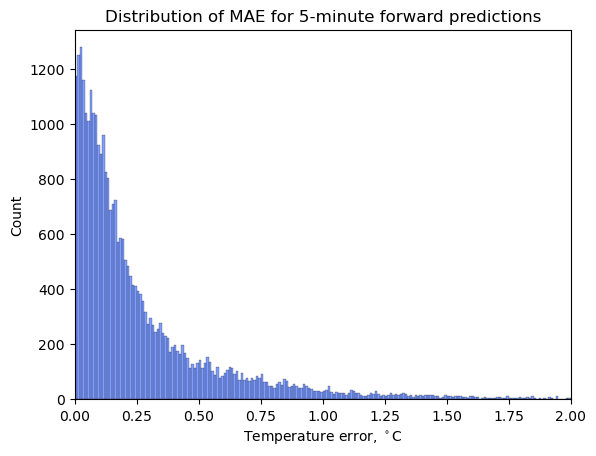

In [28]:
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0, 2.0],
    kde=False,
    palette='bright',
    legend=False
)

plt.title('Distribution of MAE for 5-minute forward predictions')
plt.xlim(0, 2.0)
plt.xlabel('Temperature error, $^\circ$C')

plt.savefig('temp_error_dist.png')
plt.show()

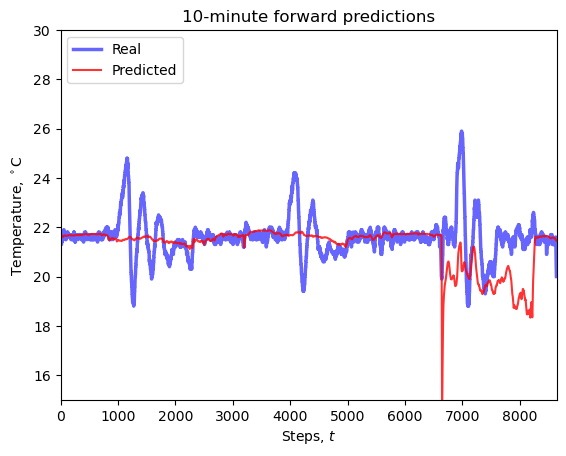

In [29]:
plt.plot(
    np.squeeze(test_targets) * temp_std + temp_mean,
    c='b',
    alpha=0.6,
    linewidth=2.5,
    label='Real'
)

plt.plot(
    vis_preds * temp_std + temp_mean,
    c='r',
    alpha=0.8,
    linewidth=1.5,
    label='Predicted'
)

plt.ylabel('Temperature, $^\circ$C')
plt.xlabel('Steps, $t$')
plt.legend(loc='upper left')
plt.title('10-minute forward predictions')

plt.ylim(15, 30)
plt.xlim(0, len(vis_preds))

plt.show()

In [30]:
np.corrcoef(test_targets, np.squeeze(vis_preds))

array([[1.        , 0.11846204],
       [0.11846204, 1.        ]])

In [31]:
np.corrcoef(np.squeeze(preds), Y_test)

array([[1.        , 0.81826288],
       [0.81826288, 1.        ]])